In [2]:
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [3]:
df_train_model = pd.read_csv('df_sentiment_embeddings.csv')

In [4]:

# Prepare data for XGBoost
X = df_train_model.drop(columns='sentiment')  # Features (Word2Vec representations)
y = df_train_model['sentiment']  # Labels


# Mapping labels from [-1, 0, 1] to [0, 1, 2]
# 0 = negative review
# 1 = neutral review
# 2 = positive review
class_mapping = {-1: 0, 0: 1, 1: 2}
y = y.map(class_mapping)


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set hyperparameters
params = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',
    'max_depth': 7,
    'learning_rate': 0.03,
    'n_estimators': 600,
    'subsample': 0.4,
    'colsample_bytree': 0.5,
    'lambda': 0.1,
    'num_class':3,
}


# Perform PCA for dimensionality reduction
n_components = 20  # Specify the number of components (adjust as needed)
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [5]:
# Create the XGBoost classifier
model = xgb.XGBClassifier(**params)

# Train the model with evaluation on a validation set
model.fit(X_train_pca, y_train, eval_set=[(X_test_pca, y_test)],  eval_metric='mlogloss', verbose=True)



[0]	validation_0-mlogloss:1.09135


[1]	validation_0-mlogloss:1.08436
[2]	validation_0-mlogloss:1.07751
[3]	validation_0-mlogloss:1.07039
[4]	validation_0-mlogloss:1.06304
[5]	validation_0-mlogloss:1.05716
[6]	validation_0-mlogloss:1.05203


c:\Users\hsohr\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-mlogloss:1.04631
[8]	validation_0-mlogloss:1.04120
[9]	validation_0-mlogloss:1.03578
[10]	validation_0-mlogloss:1.03088
[11]	validation_0-mlogloss:1.02586
[12]	validation_0-mlogloss:1.02035
[13]	validation_0-mlogloss:1.01577
[14]	validation_0-mlogloss:1.01122
[15]	validation_0-mlogloss:1.00695
[16]	validation_0-mlogloss:1.00296
[17]	validation_0-mlogloss:0.99889
[18]	validation_0-mlogloss:0.99483
[19]	validation_0-mlogloss:0.99090
[20]	validation_0-mlogloss:0.98703
[21]	validation_0-mlogloss:0.98341
[22]	validation_0-mlogloss:0.98001
[23]	validation_0-mlogloss:0.97636
[24]	validation_0-mlogloss:0.97269
[25]	validation_0-mlogloss:0.96969
[26]	validation_0-mlogloss:0.96690
[27]	validation_0-mlogloss:0.96349
[28]	validation_0-mlogloss:0.96055
[29]	validation_0-mlogloss:0.95743
[30]	validation_0-mlogloss:0.95470
[31]	validation_0-mlogloss:0.95222
[32]	validation_0-mlogloss:0.94949
[33]	validation_0-mlogloss:0.94684
[34]	validation_0-mlogloss:0.94441
[35]	validation_0-mlogl

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.1, learning_rate=0.03,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=600, n_jobs=None, num_class=3, ...)

In [13]:
from sklearn.metrics import accuracy_score

def plot_learning_curve_with_accuracy(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.grid()

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")

    # Calculate accuracy scores
    accuracy_cv = [accuracy_score(y, estimator.predict(X)) for _ in range(len(train_sizes))]
    best_accuracy = max(accuracy_cv)
    print("Best Accuracy - Cross Validation Set:", best_accuracy)
    
    return plt, best_accuracy



Best Accuracy - Cross Validation Set: 0.8813644054760806


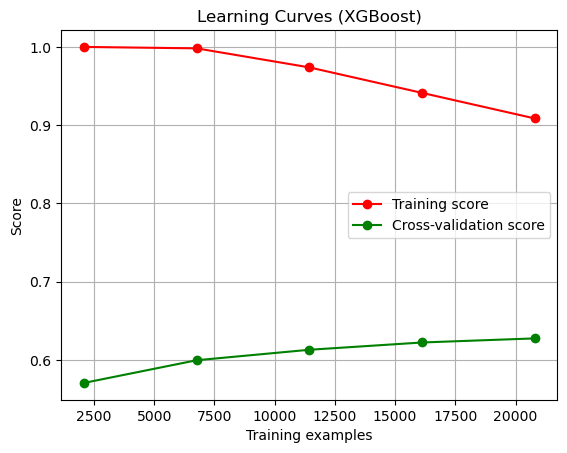

Best Accuracy: 0.8813644054760806


In [14]:
# Define the Stratified K-Fold cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Plot learning curve
title = "Learning Curves (XGBoost)"
plot, best_accuracy = plot_learning_curve_with_accuracy(model, title, X_train_pca, y_train, cv=cv, n_jobs=-1)
plot.show()


print("Best Accuracy:", best_accuracy)



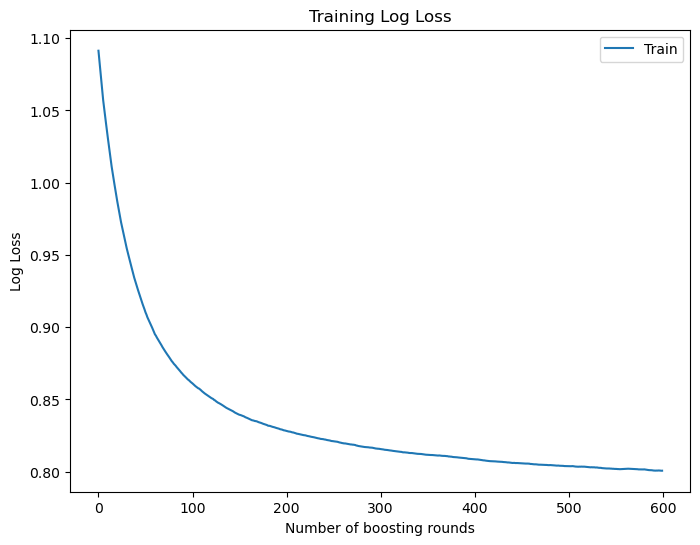

In [6]:
# Plotting the cost function (evaluation metric)
results = model.evals_result()
train_error = results['validation_0']['mlogloss']
x_axis = range(len(train_error))

plt.figure(figsize=(8, 6))
plt.plot(x_axis, train_error, label='Train')
plt.xlabel('Number of boosting rounds')
plt.ylabel('Log Loss')
plt.title('Training Log Loss')
plt.legend()
plt.show()

In [7]:
# Predict on the test dataset using cross-validation
y_pred_train = model.predict(X_train_pca)
y_pred_test = model.predict(X_test_pca)

accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy on the training dataset :", accuracy_train)
print("Accuracy on the test dataset :", accuracy_test)


# Calculate precision and recall scores
precision = precision_score(y_test, y_pred_test, average='weighted')  # 'weighted' accounts for class imbalance
recall = recall_score(y_test, y_pred_test, average='weighted')  # 'weighted' accounts for class imbalance

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

Accuracy on the training dataset : 0.8813644054760806
Accuracy on the test dataset : 0.628518689432395
Precision: 0.6173
Recall: 0.6285


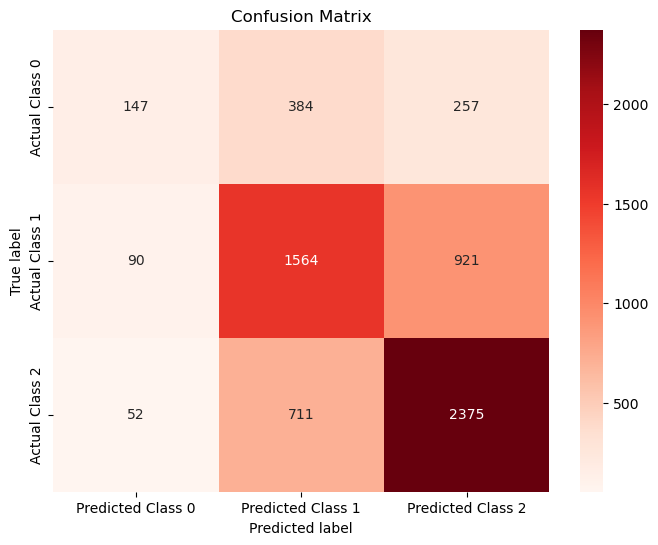

In [9]:
# Make predictions on the test set
y_pred = model.predict(X_test_pca)
num_classes = 3
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a DataFrame for better visualization
conf_matrix_df = pd.DataFrame(conf_matrix, columns=['Predicted Class ' + str(i) for i in range(num_classes)],
                              index=['Actual Class ' + str(i) for i in range(num_classes)])

# Plotting the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, cmap='Reds', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()